# Fuzzy Water Observations from Space <img align="right" src="../../../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[wofs_albers](https://explorer.sandbox.dea.ga.gov.au/wofs_albers), 
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[DEA Waterbodies](https://www.ga.gov.au/dea/products/dea-waterbodies)

## Description

This notebook demonstrates FuzzyWOfS, a reimplementation of [the WOfS classifier](https://github.com/GeoscienceAustralia/wofs/blob/master/wofs/classifier.py) over distributions. FuzzyWOfS estimates the probability that each pixel in a Landsat image is wet.

We will:

1. Show how to visualise the FuzzyWOfS classifier;
2. Show how to use FuzzyWOfS to find the probability that each pixel in a Landsat image is wet;
3. Compare the FuzzyWOfS results to MNDWI and TCW, which are band indices often used to estimate wetness.

***

## Getting started

Choose a waterbody in the "Analysis parameters" section and then run all cells.

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import datacube
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.colors
import IPython.display
import matplotlib.patches

sys.path.append("../../../Scripts")
from dea_plotting import rgb
from dea_datahandling import mostcommon_crs
from dea_waterbodies import get_waterbody
from dea_bandindices import calculate_indices

import fuzzy_wofs

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="FuzzyWOfS")

### Analysis parameters

Specify the geohash for a waterbody:

In [3]:
geohash = "r38psere6"  # Lake Cullivel

A product:

In [4]:
product = "ga_ls7e_ard_3"

A date with observations:

In [5]:
date = "2002-02-21"  # Lake Cullivel

And a buffer radius in metres:

In [6]:
buffer = 500

### Load the waterbody polygon

In [7]:
wb = get_waterbody(geohash)

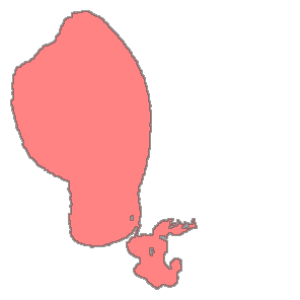

In [8]:
wb.geometry[0]

## Load the image to classify

We'll load a Landsat image to apply FuzzyWOfS to. Set up the waterbody polygon so we can use it to query:

In [9]:
gpg = datacube.utils.geometry.Geometry(wb.geometry[0], crs=wb.crs)

Identify the correct CRS for the output:

In [10]:
best_crs = mostcommon_crs(dc, product=product, query=dict(geopolygon=gpg, time=date))

Query the Landsat image:

In [11]:
bands = [
    "nbart_blue",
    "nbart_green",
    "nbart_red",
    "nbart_nir",
    "nbart_swir_1",
    "nbart_swir_2",
]

In [12]:
da = dc.load(
    product,
    geopolygon=datacube.utils.geometry.Geometry(
        wb.geometry[0].buffer(buffer), crs=wb.crs
    ),
    time=date,
    output_crs=best_crs,
    resolution=(-30, 30),
    resampling="cubic",
    measurements=bands + ["fmask"],
)

Then we can have a look at the image.

In [13]:
landsat = da.isel(time=0)

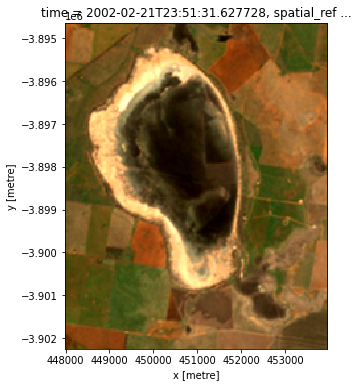

In [14]:
rgb(landsat)

## Visualise the FuzzyWOfS classifier

The structure of FuzzyWOfS is exactly the same as WOfS. The implementation, however, is a tree, so we can perform tree operations that are hard to do with WOfS. One such operation is visualising the tree. We can construct a tree diagram of WOfS:

In [15]:
dot = fuzzy_wofs.wofs.build_graphviz()

In [16]:
dot.render("wofs_tree", format="gif")

'wofs_tree.gif'

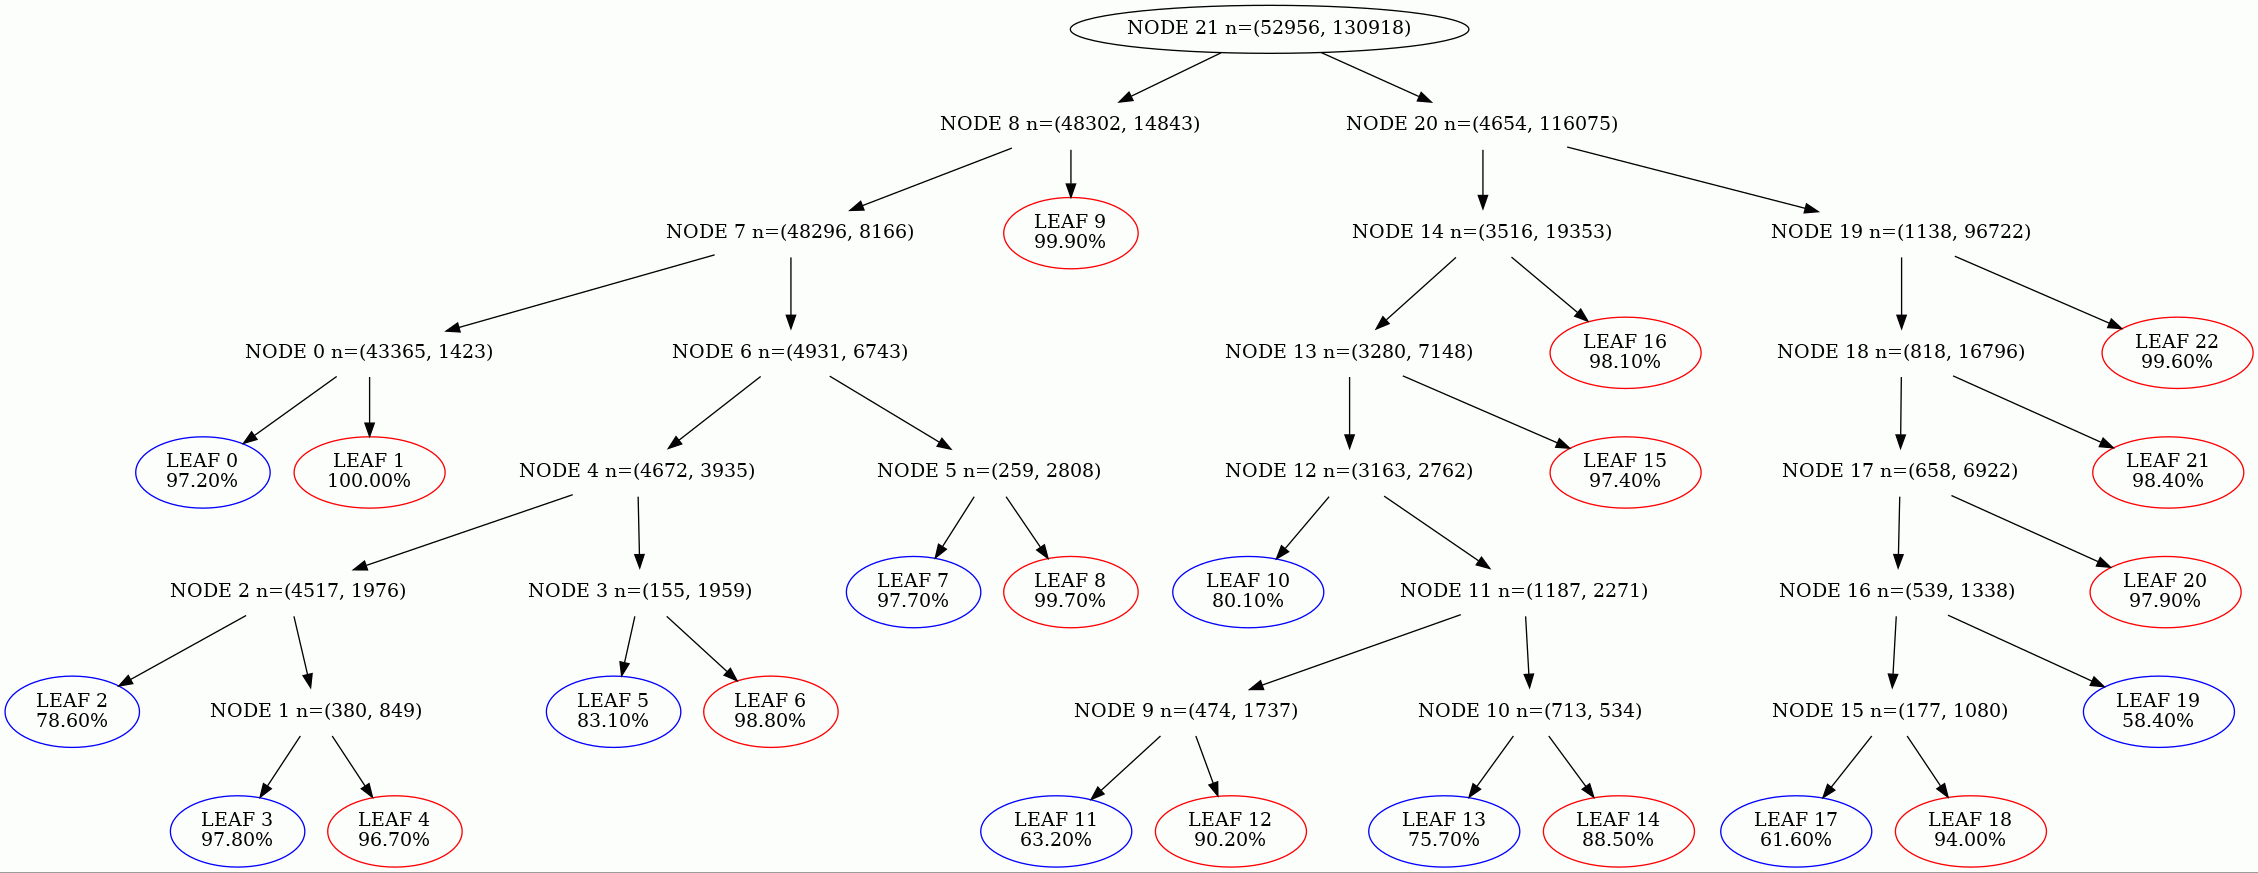

In [17]:
IPython.display.Image('wofs_tree.gif')

Dry leaf nodes are in red, and wet leaf nodes are in blue. A pixel travels probabilistically down each branch depending on its value, and ends up in a mixture of leaf nodes. The probability of the pixel being wet is then the weighted sum of the probabilities that each leaf node is wet.

We can even turn this tree into a single Python equation:

In [18]:
print(fuzzy_wofs.wofs.to_string())

((((0.97) * (1 - (erf((mu_ndi43 - 0.61) / sigma_ndi43) + 1) / 2) + (0.00) * (erf((mu_ndi43 - 0.61) / sigma_ndi43) + 1) / 2) * (1 - (erf((mu_tm7 - 323.5) / sigma_tm7) + 1) / 2) + ((((0.79) * (1 - (erf((mu_ndi43 - 0.22) / sigma_ndi43) + 1) / 2) + ((0.98) * (1 - (erf((mu_tm1 - 473.0) / sigma_tm1) + 1) / 2) + (0.03) * (erf((mu_tm1 - 473.0) / sigma_tm1) + 1) / 2) * (erf((mu_ndi43 - 0.22) / sigma_ndi43) + 1) / 2) * (1 - (erf((mu_ndi72 - -0.23) / sigma_ndi72) + 1) / 2) + ((0.83) * (1 - (erf((mu_tm1 - 379.0) / sigma_tm1) + 1) / 2) + (0.01) * (erf((mu_tm1 - 379.0) / sigma_tm1) + 1) / 2) * (erf((mu_ndi72 - -0.23) / sigma_ndi72) + 1) / 2) * (1 - (erf((mu_tm1 - 1400.5) / sigma_tm1) + 1) / 2) + ((0.98) * (1 - (erf((mu_ndi43 - -0.01) / sigma_ndi43) + 1) / 2) + (0.00) * (erf((mu_ndi43 - -0.01) / sigma_ndi43) + 1) / 2) * (erf((mu_tm1 - 1400.5) / sigma_tm1) + 1) / 2) * (erf((mu_tm7 - 323.5) / sigma_tm7) + 1) / 2) * (1 - (erf((mu_tm1 - 2083.5) / sigma_tm1) + 1) / 2) + (0.00) * (erf((mu_tm1 - 2083.5) / s

## Running FuzzyWOfS on an image

First convert your xarray from `dc.load` into a numpy array:

In [19]:
def xr_to_cube(landsat):
    """Convert an Landsat xarray Dataset to a DataArray for WOfS."""
    return landsat[bands].to_array(dim="band")

In [20]:
landsat_cube = np.array(xr_to_cube(landsat))

We can then run `wofs.predict` on this cube to predict whether each pixel is water. This should be equivalent to WOfS.

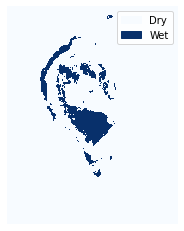

In [21]:
hard_predictions = fuzzy_wofs.wofs.predict(landsat_cube)
plt.imshow(hard_predictions, interpolation="nearest", cmap='Blues')
patches = [matplotlib.patches.Patch(color=matplotlib.cm.Blues([0, 255])[v], label=['Dry', 'Wet'][v]) for v in [0, 1]]
plt.legend(handles=patches)
plt.axis('off');

If we want probabilities, we can run `wofs.fuzzy_predict` instead. Before we can estimate probabilities, though, we need to estimate uncertainty in Landsat. For example, let's assume (fairly arbitrarily) that the noise is 11% of the median (for which there is a function to estimate the noise included in `fuzzy_wofs`).

In [22]:
landsat_noise = fuzzy_wofs.guess_noise(landsat_cube)

Then we can predict.

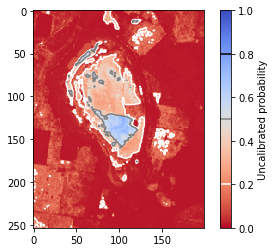

In [23]:
fuzzy_predictions = fuzzy_wofs.wofs.fuzzy_predict(landsat_cube, landsat_noise)

plt.figure()
plt.imshow(
    fuzzy_predictions, vmin=0, vmax=1, cmap="coolwarm_r", interpolation="nearest"
)
cb = plt.colorbar(label="Uncalibrated probability")
cb.ax.axhline(0.2, c="white")
cb.ax.axhline(0.5, c="grey")
cb.ax.axhline(0.8, c="black")
plt.contour(fuzzy_predictions, [0.2, 0.5, 0.8], colors=["white", "grey", "black"])

We now get an estimate of the probability that each pixel is wet. A probability of 0 means that WOfS is entirely sure that the pixel is not water. A probability of 1 means that WOfS is entirely sure that the pixel is water. The average value of the probability&mdash;and the probability in the limit of infinite noise&mdash;is the probability that any given pixel in the WOfS training set is wet, about 30%.

This value contains more information than WOfS by itself. WOfS can determine only whether a pixel is wet or dry. FuzzyWOfS can indicate how close WOfS was to classifying each pixel as wet or dry.

In WOfS, a pixel can only end up in a single leaf node: each decision is binary, and each pixel travels down one branch until it reaches a leaf. In FuzzyWOfS, pixels are split between multiple branches based on their probability of the (unobserved) true pixel value belonging in each branch. Each pixel can end up in multiple leaf nodes. The final result for a given pixel is the average of the marginal probabilities at each leaf, weighted by how much of that pixel ended up in each leaf. We decide how much of each pixel to send down each branch by modelling the probability distribution of the surface reflectance of each pixel, which we choose to model as a Gaussian.

What if the noise was really really high? For example, what if we have no SWIR bands at all? We could imagine these SWIR bands take the value of the median of some similar, known image as an assumed expected value and have really high noise.

In [24]:
median_swir = np.median(landsat_cube[-2:], axis=(1, 2))
median_swir

array([2970.5, 2025. ])

In [25]:
landsat_noswir = landsat_cube.copy()
landsat_noswir[-2:] = median_swir[:, None, None]

WOfS will output dry for every pixel in this no-SWIR case:

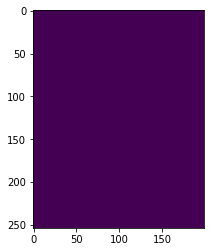

In [26]:
hard_predictions_noswir = fuzzy_wofs.wofs.predict(landsat_noswir)
plt.imshow(hard_predictions_noswir, interpolation="nearest")

But FuzzyWOfS can account for the fact that we don't know the SWIR, and evaluate WOfS over _all_ possible SWIR values:

In [27]:
really_high_noise = landsat_noise.copy()
really_high_noise[-2:] = 1000

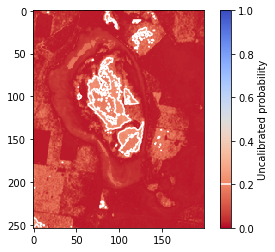

In [28]:
fuzzy_predictions_noswir = fuzzy_wofs.wofs.fuzzy_predict(
    landsat_noswir, really_high_noise
)

plt.figure()
plt.imshow(
    fuzzy_predictions_noswir, vmin=0, vmax=1, cmap="coolwarm_r", interpolation="nearest"
)
cb = plt.colorbar(label="Uncalibrated probability")
cb.ax.axhline(0.2, c="white")
plt.contour(fuzzy_predictions_noswir, [0.2], colors=["white"])

We get a low probability prediction of water.

## Visualise how WOfS classifies an image

We can also use FuzzyWOfS to investigate which leaf nodes contribute to the classification in each part of the image. Each pixel ends up in a leaf node which classifies it. Which leaf does each pixel end up in?

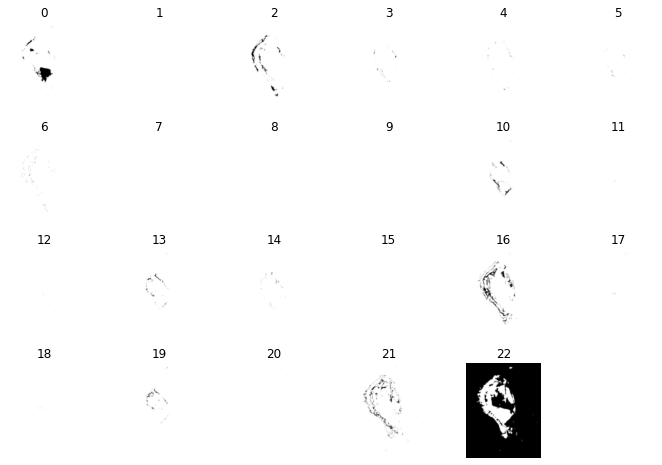

In [29]:
leaves = fuzzy_wofs.wofs.get_leaf(landsat_cube)
plt.figure(figsize=(12, 8))
for i in range(23):
    plt.subplot(4, 6, i + 1)
    plt.imshow(leaves == i, cmap="Greys", interpolation="gaussian")
    plt.axis("off")
    plt.title(i)

The dry areas in this image are mostly classified by leaf 22, while the wet areas are mostly classified by leaf 0. The areas in between are classified with a few other leaves. 

What about the fuzzy classification? Each pixel now partly ends up in each leaf. We can visualise how much of each pixel ends up in each leaf:

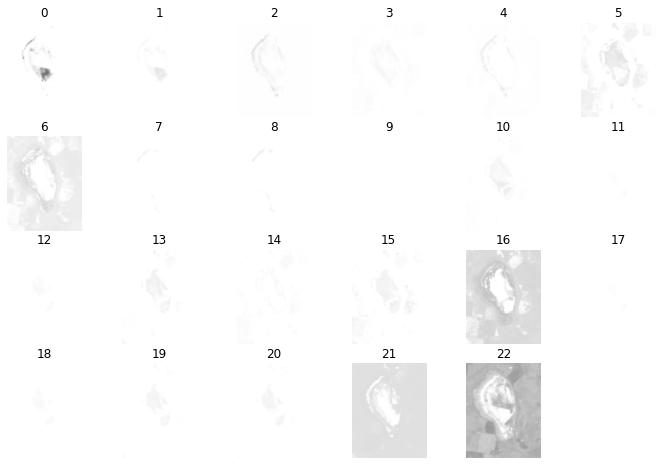

In [30]:
fuzzy_leaves = fuzzy_wofs.wofs.get_fuzzy_leaf(landsat_cube, landsat_noise)
plt.figure(figsize=(12, 8))
for i in range(23):
    plt.subplot(4, 6, i + 1)
    plt.imshow(fuzzy_leaves[i], cmap="Greys", interpolation="gaussian", vmin=0, vmax=1)
    plt.axis("off")
    plt.title(i)

We can see that all leaves contribute to the prediction in different amounts. This is the key difference between WOfS and FuzzyWOfS: in FuzzyWOfS, all leaves contribute to the prediction, while in WOfS, each prediction is based only on one leaf.

## Comparison to other wetness measures

How does FuzzyWOfS compare to Tasseled Cap Wetness (TCW) and the Modified Normalised Difference Water Index (MNDWI), as well as the all-time summary of WOfS?

Load TCW, MNDWI, and the WOfS summary:

In [31]:
tcw = calculate_indices(da, index="TCW", collection="ga_ls_3")
mndwi = calculate_indices(da, index="MNDWI", collection="ga_ls_3")
wofs_summary = dc.load("wofs_filtered_summary", like=da.drop("time"))

/env/lib/python3.6/site-packages/datacube/api/core.py:345: UserWarning: Discarding nonzero nanoseconds in conversion
  query = Query(self.index, **kwargs)


Then we can plot them all together. We'll outline the 5% maximum extent that DEA Waterbodies uses, and also the 50% mark for FuzzyWOfS.

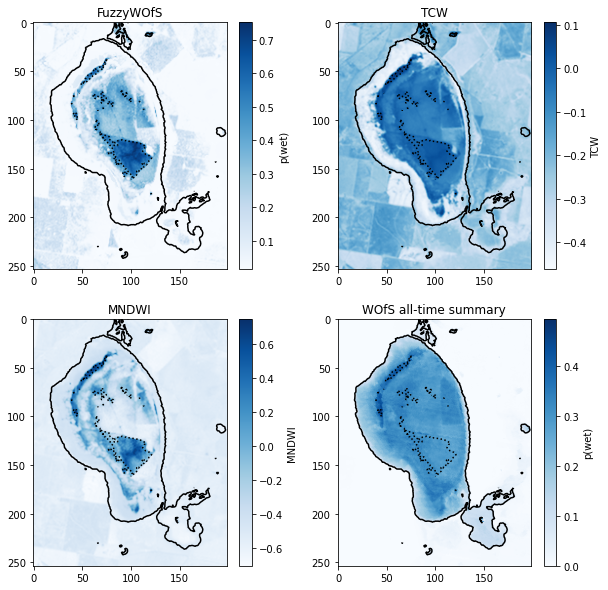

In [32]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.title("FuzzyWOfS")
plt.imshow(fuzzy_predictions, cmap="Blues")
plt.colorbar(label='p(wet)')
plt.contour(fuzzy_predictions, [0.5], colors="black", linestyles=":")
plt.contour(wofs_summary.wofs_filtered_summary.isel(time=0), [0.05], colors="black")
plt.subplot(2, 2, 2)
plt.title("TCW")
plt.imshow(tcw.isel(time=0).TCW, cmap="Blues")
plt.colorbar(label='TCW')
plt.contour(fuzzy_predictions, [0.5], colors="black", linestyles=":")
plt.contour(wofs_summary.wofs_filtered_summary.isel(time=0), [0.05], colors="black")
plt.subplot(2, 2, 3)
plt.title("MNDWI")
plt.imshow(mndwi.isel(time=0).MNDWI, cmap="Blues")
plt.colorbar(label='MNDWI')
plt.contour(fuzzy_predictions, [0.5], colors="black", linestyles=":")
plt.contour(wofs_summary.wofs_filtered_summary.isel(time=0), [0.05], colors="black")
plt.subplot(2, 2, 4)
plt.title("WOfS all-time summary")
plt.imshow(wofs_summary.wofs_filtered_summary.isel(time=0), vmin=0, cmap="Blues")
plt.colorbar(label='p(wet)')
plt.contour(fuzzy_predictions, [0.5], colors="black", linestyles=":")
plt.contour(wofs_summary.wofs_filtered_summary.isel(time=0), [0.05], colors="black")

Bluer regions of the above maps indicate a higher likelihood of open water. All of the different scene-based measures show different amounts of water, though the water they show tends to be within the boundaries of the lake. TCW shows much more water, while MNDWI shows sparser water. This shows how FuzzyWOfS provides an alternative to TCW and MNDWI for continuous (i.e. non-binary) water predictions on a scene-by-scene basis in a way that is consistent with, and augments, the existing WOfS product.

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** November 2020

**Compatible datacube version:** 

In [33]:
print(datacube.__version__)

1.8.3


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)